#**Problem statement**:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

##Solution Flow
1. Data Reading/Data Understanding
2. Dataset Creation
3. Dataset visualisation
4. Model Building & training
5. Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting
6. Model Building & training on the augmented data
7. Find the distribution of classes in the training dataset
8. Handling class imbalances
9. Model Building & training on the rectified class imbalance data


##1. Data Reading/Data Understanding


### Importing Skin Cancer Data

###Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [1]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
# Paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

##2. Dataset Creation

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


##3. Dataset visualisation
#### code to visualize one instance of all the nine classes present in the dataset

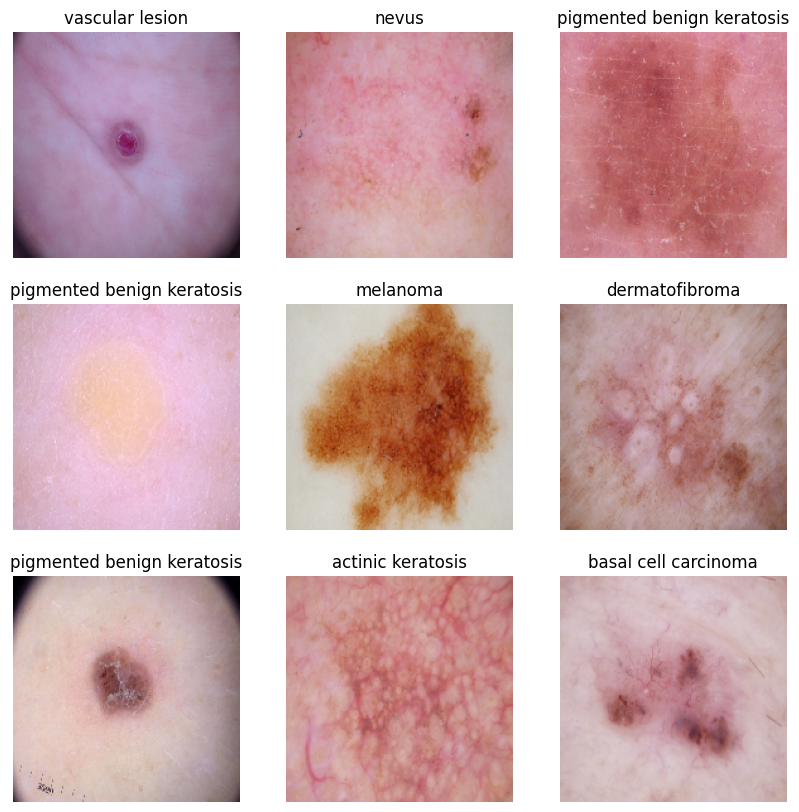

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### using training data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##4.Model Building & training
####Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [17]:
### with appropirate optimiser and loss function
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 338s 1s/step - loss: 2.0181 - accuracy: 0.2316 - val_loss: 1.8505 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.7132 - accuracy: 0.3984 - val_loss: 1.5098 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4226 - accuracy: 0.4967 - val_loss: 1.3644 - val_accuracy: 0.5391
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2817 - accuracy: 0.5558 - val_loss: 1.4215 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1962 - accuracy: 0.5843 - val_loss: 1.3517 - val_accuracy: 0.5638
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1211 - accuracy: 0.5971 - val_loss: 1.3491 - val_accuracy: 0.5526
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.0268 - accuracy: 0.6323 - val_loss: 1.4466 - val_accuracy: 0.5436
Epoch 8/20
56

### Visualizing training results

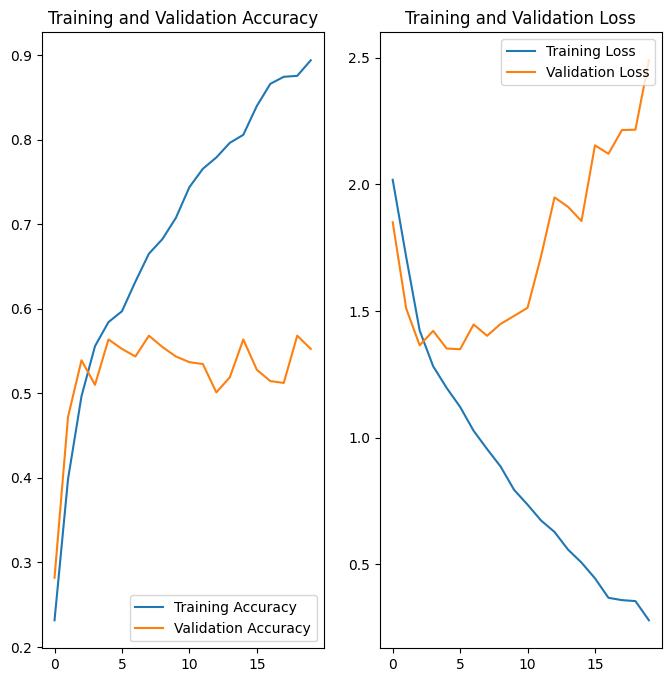

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###**Findings are**

###In the plots above, difference between the training accuracy and validation accuracy is big, training accuracy is more while validation accuracy considerably less. this is the sign of **overfitting**.

##5. Choosing an appropriate data augmentation strategy to resolve overfitting

In [22]:
# after you have analysing the model fit history for presence of underfit or overfit, choosing an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(height_factor= (-0.1, 0.1),width_factor=(-0.1, 0.1)),
  ]
)

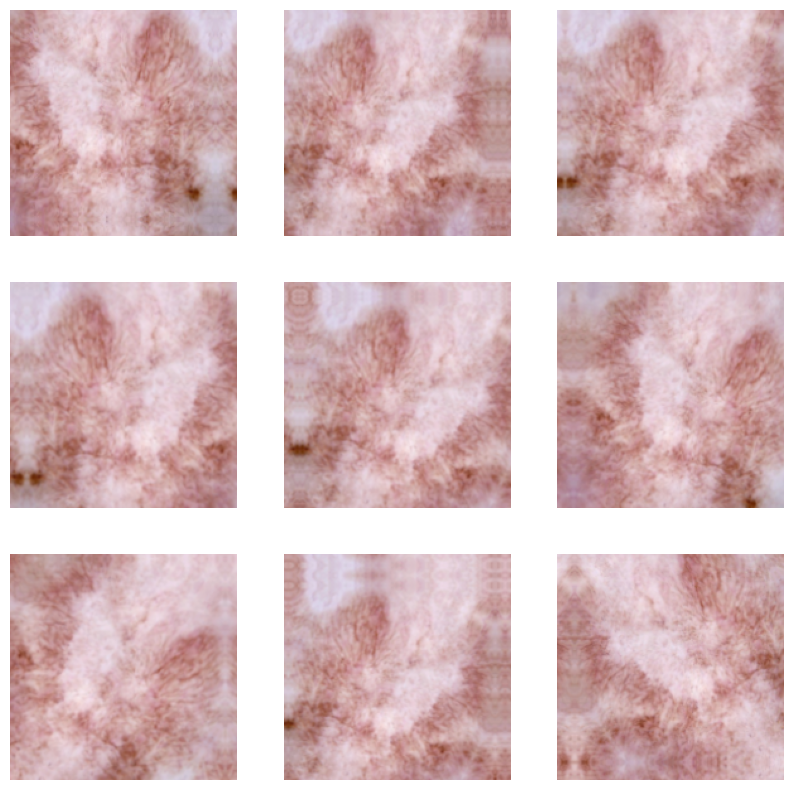

In [23]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##6. Model Building & training on the augmented data
### Create the model, compile and train the model


In [24]:
## using Dropout layer as there is an evidence of overfitting in the findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [25]:
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 39ms/step - loss: 1.9963 - accuracy: 0.2645 - val_loss: 1.8406 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.7372 - accuracy: 0.3990 - val_loss: 1.5758 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5335 - accuracy: 0.4715 - val_loss: 1.4948 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4440 - accuracy: 0.4883 - val_loss: 1.3724 - val_accuracy: 0.5391
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3766 - accuracy: 0.5173 - val_loss: 1.3828 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3678 - accuracy: 0.5162 - val_loss: 1.4974 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3146 - accuracy: 0.5251 - val_loss: 1.3375 - val_accuracy: 0.5459
Epoch 8/20
56

### Visualizing the results

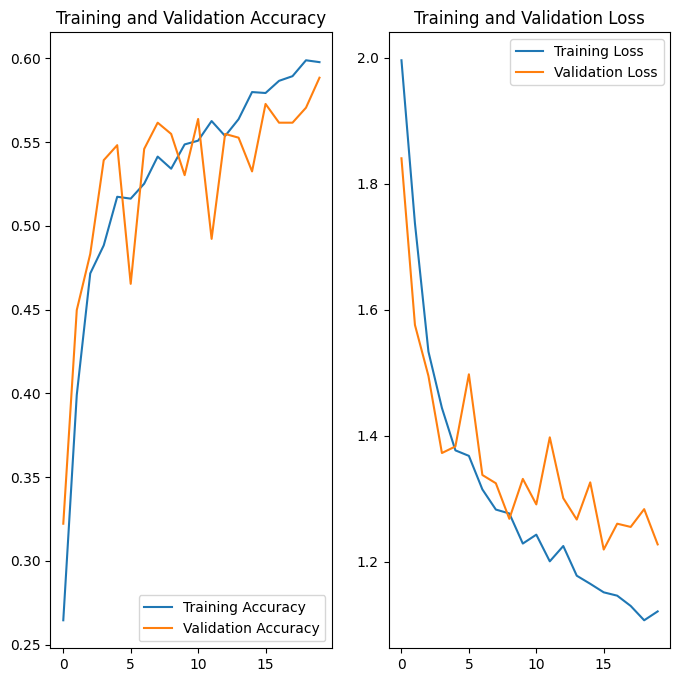

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings**: major improvement compared to the previous model run, over fit issue is sorted, but results are not satisfactory. training accuracy is very less and model is **underfitting**. we will check for distribution of class to address this.

##7. Find the distribution of classes in the training dataset
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
#preparing list of paths for image files
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [29]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,squamous cell carcinoma
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,squamous cell carcinoma
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,squamous cell carcinoma
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,squamous cell carcinoma
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,squamous cell carcinoma
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma


Class=7, n=181 (8.084%)
Class=4, n=357 (15.945%)
Class=8, n=139 (6.208%)
Class=2, n=95 (4.243%)
Class=6, n=77 (3.439%)
Class=0, n=114 (5.092%)
Class=5, n=462 (20.634%)
Class=3, n=438 (19.562%)
Class=1, n=376 (16.793%)


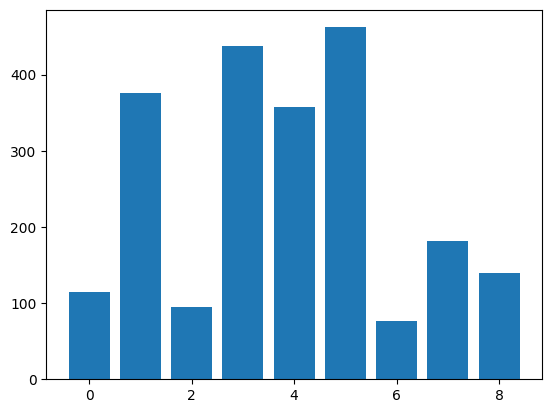

In [30]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

 #### **Findings :**
#### - Which class has the least number of samples?
        seborrheic keratosis[ class - 6 ] has least no of samples
#### - Which classes dominate the data in terms proportionate number of samples?
        pigmented benign keratosis [ class - 5 ] dominates number of samples


##8. Handling class imbalances
#### **Context:** **we** can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
 path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(600) ## We are adding 600 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A2A3A95A530>: 100%|██████████| 600/600 [00:21<00:00, 28.03 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A2A285BBD60>: 100%|██████████| 600/600 [00:23<00:00, 25.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A29F860BCA0>: 100%|██████████| 600/600 [00:22<00:00, 26.36 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A29F8340460>: 100%|██████████| 600/600 [01:43<00:00,  5.80 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7A29F8812F50>: 100%|██████████| 600/600 [01:43<00:00,  5.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A29F88130A0>: 100%|██████████| 600/600 [00:21<00:00, 27.73 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A29F83419F0>: 100%|██████████| 600/600 [00:51<00:00, 11.59 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A29F85DC9D0>: 100%|██████████| 600/600 [00:24<00:00, 24.76 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A2ABE2ACEE0>: 100%|██████████| 600/600 [00:23<00:00, 25.12 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

5400


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025264.jpg_9441051b-1573-4ebc-a0b0-f4d8aa391256.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031743.jpg_db5d29ea-c6c5-45c9-852e-27f2bbfe8f48.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031874.jpg_88e6e950-b868-4907-a482-8a9e5afdefd0.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031191.jpg_3f693f8e-1932-4054-9add-905c8529ad1d.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squ

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [40]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-42-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [43]:
new_df['Label'].value_counts()

pigmented benign keratosis    1062
melanoma                      1038
basal cell carcinoma           976
nevus                          957
squamous cell carcinoma        781
vascular lesion                739
actinic keratosis              714
dermatofibroma                 695
seborrheic keratosis           677
Name: Label, dtype: int64

So, now we have added 600 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

##9. Model Building & training on the rectified class imbalance data

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [45]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7639 files belonging to 9 classes.
Using 6112 files for training.


####  Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7639 files belonging to 9 classes.
Using 1527 files for validation.


####  Create your model (make sure to include normalization)

In [47]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

####  Compile your model (Choose optimizer and loss function appropriately)

In [48]:
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train your model

In [49]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
191/191 [==============================] - 45s 77ms/step - loss: 1.6651 - accuracy: 0.3779 - val_loss: 1.3059 - val_accuracy: 0.5213
Epoch 2/30
191/191 [==============================] - 5s 28ms/step - loss: 1.2137 - accuracy: 0.5597 - val_loss: 1.1937 - val_accuracy: 0.5553
Epoch 3/30
191/191 [==============================] - 6s 30ms/step - loss: 0.9948 - accuracy: 0.6392 - val_loss: 1.0148 - val_accuracy: 0.6202
Epoch 4/30
191/191 [==============================] - 6s 29ms/step - loss: 0.8216 - accuracy: 0.6988 - val_loss: 0.8879 - val_accuracy: 0.6830
Epoch 5/30
191/191 [==============================] - 6s 30ms/step - loss: 0.6474 - accuracy: 0.7726 - val_loss: 0.7487 - val_accuracy: 0.7348
Epoch 6/30
191/191 [==============================] - 6s 29ms/step - loss: 0.5375 - accuracy: 0.8105 - val_loss: 0.7193 - val_accuracy: 0.7446
Epoch 7/30
191/191 [==============================] - 6s 29ms/step - loss: 0.4238 - accuracy: 0.8496 - val_loss: 0.7779 - val_accuracy: 0.739

#### **Todo:**  Visualize the model results

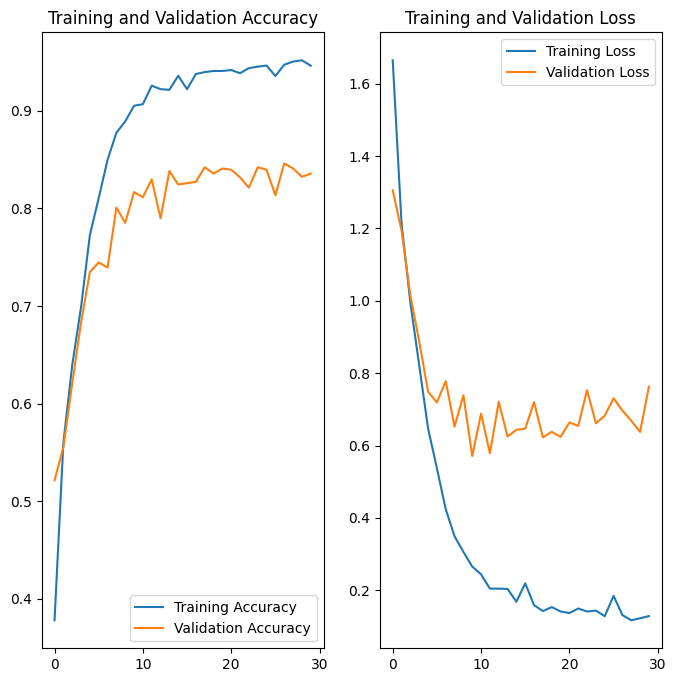

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzed results here. Did we get rid of underfitting/overfitting? Did class rebalance help?



By Analysing above chart,
- we can clearly see we have **overcome** **underfitting**.
- **Class rebalance helped** to address underfitting, and also we could able to get better fit model  